In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
import requests 
%matplotlib inline
sess = tf.Session()

In [2]:
#load data
birthdata_url = 'http://springer.bme.gatech.edu/Ch17.Logistic/Logisticdat/lowbwt.dat'
birth_file = requests.get(birthdata_url)
birth_data = birth_file.text.split('\r\n')[5:]
birth_header = [x for x in birth_data[0].split(' ') if len(x)>=1]
birth_data = [[float(x) for x in y.split(' ') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]
# Pull out target variable
y_vals = np.array([x[1] for x in birth_data])
# Pull out predictor variables (not id, not target, and not birthweight)
x_vals = np.array([x[2:10] for x in birth_data])

In [3]:
#set the random seed
seed = 3
tf.set_random_seed(seed)
np.random.seed(seed)
batch_size = 100

In [4]:
#split data
train_indices = np.array(np.random.choice(len(x_vals),round(len(x_vals)*0.8),replace=False))
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))

x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [5]:
#normalize columns
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min)/(col_max - col_min)

x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

In [6]:
#create funciton to initialize both the weights and biases
def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random_normal(shape=shape, stddev=st_dev))
    return(weight)

def init_bias(shape, st_dev):
    bias = tf.Variable(tf.random_normal(shape=shape, stddev=st_dev))
    return(bias)

In [7]:
#initialize placeholders
x_data = tf.placeholder(dtype=tf.float32, shape=[None,8])
y_target = tf.placeholder(dtype=tf.float32, shape=[None,1])

In [8]:
#The fully connected layer will be used three times for all three hidden layers. To prevent repeated code, we will create
# a layer function to use when we initialize our model
def fully_connected(input_layer, weights, biases):
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    return(tf.nn.relu(layer))

In [9]:
#We will now create our model. For each layer (and output layer) we will initialize a weight matrix, bias matrix, 
#and the fully connected alyer. For this example, we will use hidden layers of sizes 25,10 and 3

#Create first layer (25 hidden nodes)
weight_1 = init_weight(shape=[8,25], st_dev=10.0)
bias_1 = init_bias(shape=[25], st_dev=10.0)
layer_1 = fully_connected(input_layer=x_data, weights=weight_1, biases=bias_1)

#Create second layer (10 hiddent nodes)
weight_2 = init_weight(shape=[25,10], st_dev=10.0)
bias_2 = init_bias(shape=[10], st_dev=10.0)
layer_2 = fully_connected(input_layer=layer_1, weights=weight_2, biases=bias_2)

#Create second layer (3 hiddent nodes)
weight_3 = init_weight(shape=[10,3], st_dev=10.0)
bias_3 = init_bias(shape=[3], st_dev=10.0)
layer_3 = fully_connected(input_layer=layer_2, weights=weight_3, biases=bias_3)

#Create output layer (1 output value)
weight_4 = init_weight(shape=[3,1], st_dev=10.0)
bias_4 = init_bias(shape=[3], st_dev=10.0)
final_output = fully_connected(input_layer=layer_3, weights=weight_4, biases=bias_4)

In [10]:
#We will now use the L1 loss function (absolute value), declare our optimizer (Adam optimization), and initialize 
#our variables. 
loss = tf.reduce_mean(tf.abs(y_target - final_output))
opt = tf.train.AdamOptimizer(0.05)
train_step = opt.minimize(loss)

init = tf.global_variables_initializer()
sess.run(init)

In [11]:
#train model for 200 iterations. We will also store the train and test loss.
loss_vec = []
test_loss = []

for i in range(200):
    #Choose random indices for batch selection.
    rand_index = np.random.choice(len(x_vals_train),size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    #Run the training step.
    sess.run(train_step, feed_dict={x_data:rand_x, y_target:rand_y})
    #Get and store the train loss
    temp_loss = sess.run(loss, feed_dict={x_data:rand_x, y_target:rand_y})
    loss_vec.append(temp_loss)
    #Get and store the test loss
    test_temp_loss = sess.run(loss, feed_dict={x_data:x_vals_test, y_target:np.transpose([y_vals_test])})
    test_loss.append(test_temp_loss)
    
    if(i+1)%25==0:
        print('Generation: ' + str(i+1) + '. Loss = ' + str(temp_loss))

Generation: 25. Loss = 4209.536
Generation: 50. Loss = 23.682585
Generation: 75. Loss = 22.958908
Generation: 100. Loss = 0.4421255
Generation: 125. Loss = 5.7921004
Generation: 150. Loss = 0.4319339
Generation: 175. Loss = 0.3833172
Generation: 200. Loss = 0.35870203


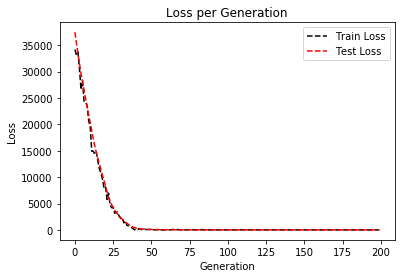

In [12]:
#Plot
plt.plot(loss_vec, 'k--', label='Train Loss')
plt.plot(test_loss, 'r--', label='Test Loss')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [13]:
#Accuracy
actuals = np.array([x[1] for x in birth_data])
test_actuals = actuals[test_indices]
train_actuals = actuals[train_indices]
test_preds = [x[0] for x in sess.run(final_output, feed_dict={x_data:x_vals_test})]
train_preds = [x[0] for x in sess.run(final_output, feed_dict={x_data:x_vals_train})]
test_preds = np.array([1.0 if x<2500 else 0.0 for x in test_preds])
train_preds = np.array([1.0 if x<2500 else 0.0 for x in train_preds])
#Print out accuracies
test_acc = np.mean([x==y for x,y in zip(test_preds,test_actuals)])
train_acc = np.mean([x==y for x,y in zip(train_preds,train_actuals)])
print('On predicting the category of low birthweight from regression output (<2500g): ')
print('Test Accuracy: {}'.format(test_acc))
print('Train Accuracy: {}'.format(train_acc))

On predicting the category of low birthweight from regression output (<2500g): 
Test Accuracy: 0.21621621621621623
Train Accuracy: 0.3129251700680272
